Cell 1 — Install packages

In [1]:
# # If you're on Colab, this will take ~1–2 minutes
# !pip install -q -U transformers datasets accelerate pandas matplotlib numpy
# # Install Chronos directly from the official repo (stable PyPI name can lag)
# !pip install -q -U git+https://github.com/amazon-science/chronos-forecasting.git

# Uninstall any conflicting higher versions
!pip uninstall -y pandas numpy

# Reinstall Colab-compatible versions
!pip install pandas==2.2.2 numpy==1.26.4

# Install required ML packages (don't upgrade pandas/numpy again)
!pip install -U transformers==4.44.2 accelerate datasets matplotlib

# Install Chronos
!pip install git+https://github.com/amazon-science/chronos-forecasting.git


Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 99.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 92.5 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you h

Cell 2 — Imports & helpers

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta
from typing import Dict, List

from chronos import ChronosPipeline  # provided by the package you just installed

# ---- small helpers ----
def train_test_split_by_ratio(df: pd.DataFrame, ratio: float = 0.8):
    """Time-ordered split."""
    n = len(df)
    cut = int(n * ratio)
    return df.iloc[:cut], df.iloc[cut:]

def make_series(start: pd.Timestamp, values: List[float]) -> Dict:
    """Chronos expects dicts with 'start' and 'target' (list of floats)."""
    return {"start": pd.Timestamp(start), "target": list(map(float, values))}

def quantiles_from_samples(samples: np.ndarray, q=(0.05, 0.5, 0.95)):
    """
    samples: (num_samples, horizon) OR (num_series, num_samples, horizon)
    returns dict of quantile arrays keyed by q
    """
    if samples.ndim == 2:
        # (num_samples, horizon)
        qs = {qq: np.quantile(samples, qq, axis=0) for qq in q}
    elif samples.ndim == 3:
        # (num_series, num_samples, horizon)
        qs = {qq: np.quantile(samples, qq, axis=1) for qq in q}
    else:
        raise ValueError("Unexpected samples shape")
    return qs

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-6, None))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}


2025-08-20 11:40:16.711224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755690016.895452      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755690016.950758      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Cell 3 — Load your dengue.csv and basic cleaning

In [3]:

# If the file is in your drive, set the correct path; on Colab, upload via the left Files pane or:
# from google.colab import files; files.upload()
CSV_PATH = "/kaggle/input/america-dengue-data/dengue data 17-07-2025.csv"  # change if needed

# Parse date: your 'week_start_date' looks like "30-04-1990" (DD-MM-YYYY) -> dayfirst=True
df = pd.read_csv(CSV_PATH)
df['week_start_date'] = pd.to_datetime(df['week_start_date'], dayfirst=True, errors='coerce')

# Keep only the columns we need for univariate forecasting per city
cols_needed = ['city', 'week_start_date', 'total_cases']
missing = [c for c in cols_needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df[cols_needed].dropna().copy()

# Sort by time within each city
df = df.sort_values(['city', 'week_start_date']).reset_index(drop=True)

# Show a quick peek
print(df.head())
print("\nCities:", df['city'].unique())
print("\nDate Range:", df['week_start_date'].min(), "→", df['week_start_date'].max())


  city week_start_date  total_cases
0   iq      2000-07-01            0
1   iq      2000-07-08            0
2   iq      2000-07-15            0
3   iq      2000-07-22            0
4   iq      2000-07-29            0

Cities: ['iq' 'sj']

Date Range: 1990-04-30 00:00:00 → 2010-06-25 00:00:00


Cell 4 — Create per-city train/test splits

In [4]:
city_groups = dict(tuple(df.groupby('city', sort=False)))

splits = {}
for city, cdf in city_groups.items():
    train_df, test_df = train_test_split_by_ratio(cdf, ratio=0.8)  # adjust ratio if desired
    # Safety: ensure we have at least a few points in each split
    if len(train_df) < 20 or len(test_df) < 4:
        print(f"Warning: {city} has a very small split (train={len(train_df)}, test={len(test_df)}).")
    splits[city] = {"train": train_df, "test": test_df}

print({k: (len(v['train']), len(v['test'])) for k, v in splits.items()})


{'iq': (416, 104), 'sj': (748, 188)}


Cell 5 — Load Chronos (T5-Efficient Small)

In [5]:
# Model choices include: "amazon/chronos-t5-tiny", "amazon/chronos-t5-mini", "amazon/chronos-t5-small", ...
# We'll use "small" as requested/performance-friendly:
model_id = "amazon/chronos-t5-small"

pipe = ChronosPipeline.from_pretrained(
    model_id,
    device_map="auto"  # will use GPU if available
)

print("Loaded:", model_id)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Loaded: amazon/chronos-t5-small


Cell 6 — Build series for each city and forecast the test horizon

In [7]:
import torch  # <-- add this

results = {}

for city, parts in splits.items():
    train_df = parts['train']
    test_df = parts['test']

    # Chronos expects tensors, not dicts
    series = [torch.tensor(train_df['total_cases'].values, dtype=torch.float32)]

    horizon = len(test_df)

    fc_samples_list = pipe.predict(
        series,
        prediction_length=horizon,
        num_samples=200,
        temperature=1.0,
        top_k=None, top_p=None
    )

    fc_samples = fc_samples_list[0]  # (num_samples, horizon)
    q = quantiles_from_samples(fc_samples, q=(0.05, 0.5, 0.95))
    y_hat = q[0.5]
    y_lo = q[0.05]
    y_hi = q[0.95]

    fc_dates = test_df['week_start_date'].tolist()
    y_true = test_df['total_cases'].to_numpy(dtype=float)
    m = metrics(y_true, y_hat)

    res_df = pd.DataFrame({
        "date": fc_dates,
        "actual": y_true,
        "pred": y_hat,
        "pred_lo": y_lo,
        "pred_hi": y_hi,
        "city": city
    })
    results[city] = {"metrics": m, "forecast_df": res_df, "train_df": train_df, "test_df": test_df}

# Print summary
for city, stuff in results.items():
    print(f"\n[{city}] Metrics on test set ({len(stuff['forecast_df'])} points):")
    for k, v in stuff["metrics"].items():
        print(f"  {k}: {v:.3f}")



[iq] Metrics on test set (104 points):
  MAE: 7.059
  RMSE: 12.002
  MAPE%: 34500552.250

[sj] Metrics on test set (188 points):
  MAE: 17.583
  RMSE: 30.430
  MAPE%: 3763093.135


Cell 7 — Plot actual vs. forecast (per city)

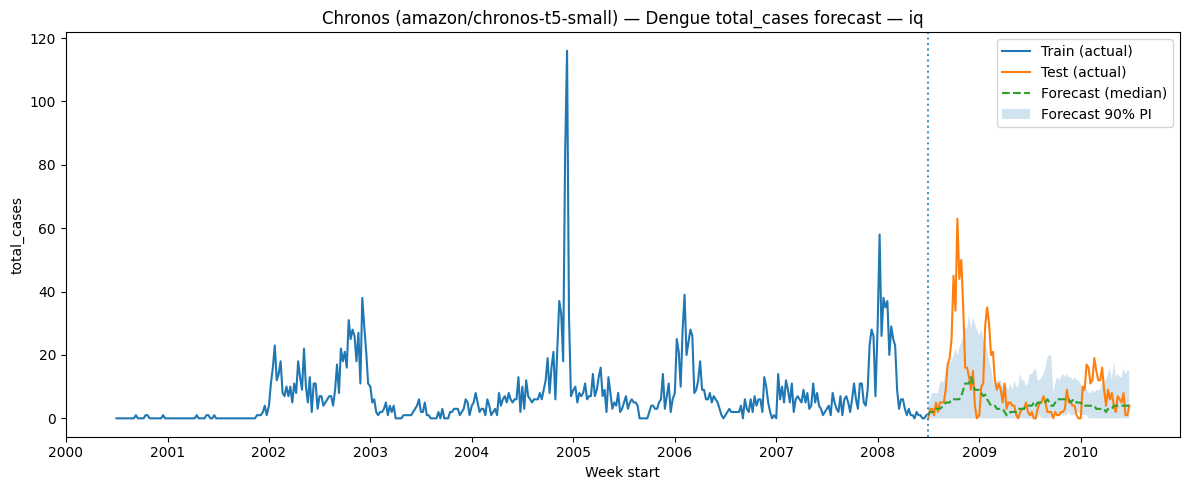

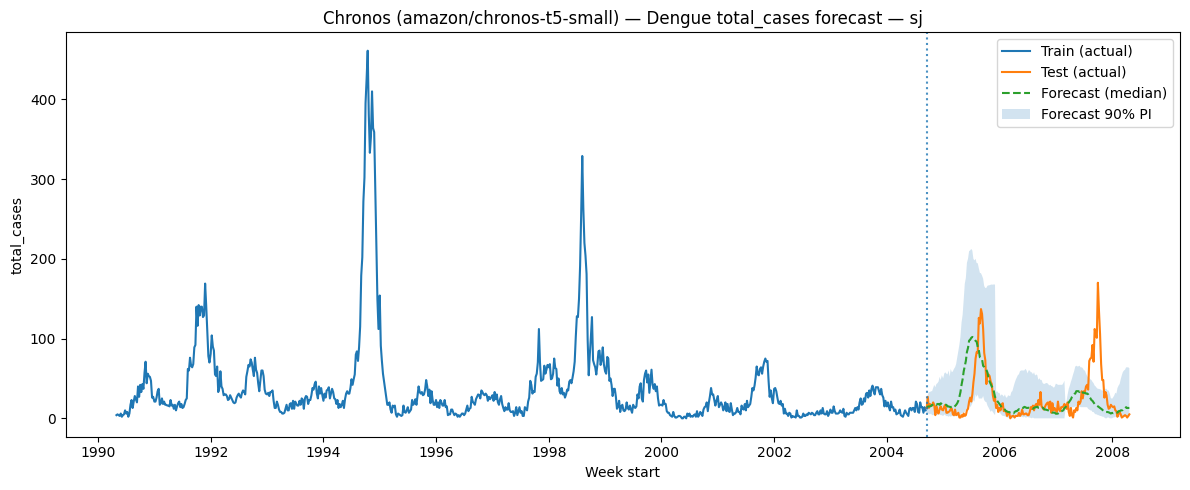

In [8]:
# One chart per city with prediction interval
for city, stuff in results.items():
    train_df = stuff['train_df']
    test_df = stuff['test_df']
    fdf = stuff['forecast_df']

    plt.figure(figsize=(12, 5))
    # History
    plt.plot(train_df['week_start_date'], train_df['total_cases'], label="Train (actual)")
    # Test actual
    plt.plot(test_df['week_start_date'], test_df['total_cases'], label="Test (actual)")
    # Forecast median
    plt.plot(fdf['date'], fdf['pred'], linestyle="--", label="Forecast (median)")
    # Prediction interval
    plt.fill_between(fdf['date'], fdf['pred_lo'], fdf['pred_hi'], alpha=0.2, label="Forecast 90% PI")

    # Split marker
    plt.axvline(test_df['week_start_date'].iloc[0], linestyle=":", alpha=0.8)

    plt.title(f"Chronos ({model_id}) — Dengue total_cases forecast — {city}")
    plt.xlabel("Week start")
    plt.ylabel("total_cases")
    plt.legend()
    plt.tight_layout()
    plt.show()


Cell 8 — Combine cities and show overall metrics/plot

Overall metrics across cities:
  MAE: 13.834
  RMSE: 25.445
  MAPE%: 14710681.312


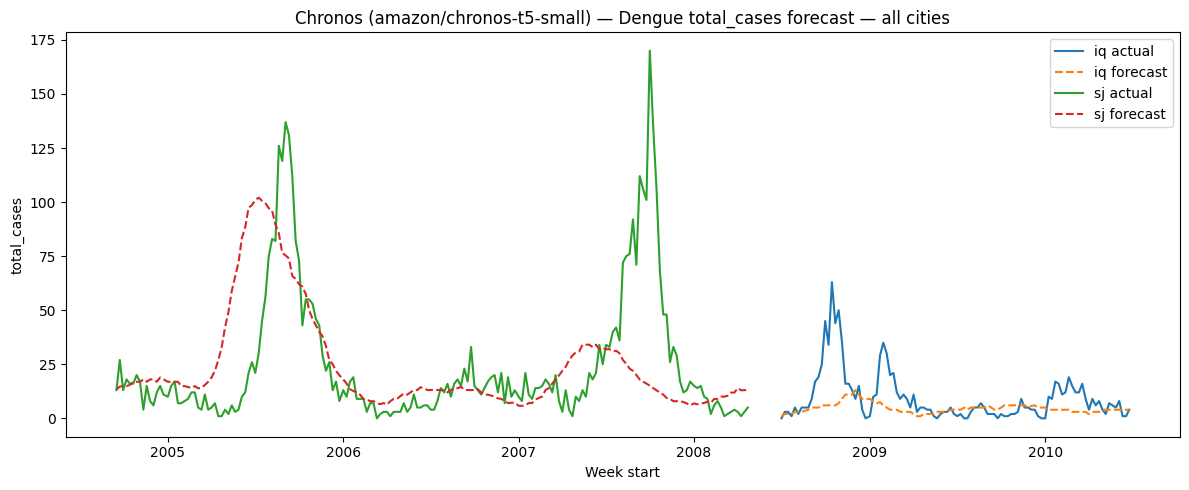

In [9]:
# Concatenate all per-city forecast rows
all_fc = pd.concat([v["forecast_df"] for v in results.values()], ignore_index=True)
# For overall metrics, weight equally by points:
overall_m = metrics(all_fc["actual"].to_numpy(), all_fc["pred"].to_numpy())

print("Overall metrics across cities:")
for k, v in overall_m.items():
    print(f"  {k}: {v:.3f}")

# Plot combined actual vs forecast (stacked time series by city)
plt.figure(figsize=(12,5))
for city, stuff in results.items():
    fdf = stuff['forecast_df']
    plt.plot(fdf['date'], fdf['actual'], label=f"{city} actual")
    plt.plot(fdf['date'], fdf['pred'], linestyle="--", label=f"{city} forecast")
plt.title(f"Chronos ({model_id}) — Dengue total_cases forecast — all cities")
plt.xlabel("Week start")
plt.ylabel("total_cases")
plt.legend()
plt.tight_layout()
plt.show()


Cell 9 — (Optional) Export forecasts to CSV

In [ ]:
# out_path = "chronos_forecasts_dengue.csv"
# pd.concat([v["forecast_df"] for v in results.values()], ignore_index=True).to_csv(out_path, index=False)
# print("Saved:", os.path.abspath(out_path))


Notes & tweaks

Horizon: We forecast exactly the length of your test split. Change the split ratio in Cell 4 or set a fixed horizon if you prefer.

Uncertainty: Increase num_samples in Cell 6 for smoother prediction intervals.

Per-city models: Chronos is univariate per series; we forecast each city independently using only total_cases.

Exogenous features: Your dataset has rich covariates (NDVI, reanalysis, station data). Chronos (as used here) doesn’t take exogenous covariates directly. If you want to use them, a common approach is to train a regression model for total_cases using these features and then forecast the residuals with Chronos, or use a multivariate model (e.g., AutoGluon-TS + Chronos-Bolt or a classic model like XGBoost + lag features). I can wire that up if you’d like.

If you hit any errors in a cell (e.g., file path, date parsing), paste the error text and I’ll adjust the code for you.

In [ ]:
# Restart runtime to clear any lingering issues from interrupted installation
import os
os.kill(os.getpid(), 9)